# Machine Learning for Economic Analysis
### Project 2: Predicting Housing Prices

#### Authors:
Samir Sulejmani (16-726-747), 
Felix Jost (15-067-861),
Marc Zeugin (15-708-993),
Simon Cappelli (11-945-813)



In [ ]:
# Imports

import numpy as np
import pandas as pd
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import  LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import RobustScaler

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# Pandas options for easier visualization
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

# For graphs
sns.set_style("whitegrid")
sns.set_palette("cubehelix")

# Surpress warnings
import warnings
warnings.filterwarnings(action="ignore")


#### 1. Data Import and Cleaning

In [ ]:
# Read in the dataset as a dataframe

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# First lets remove 'ID' as it is not needed for predictions.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

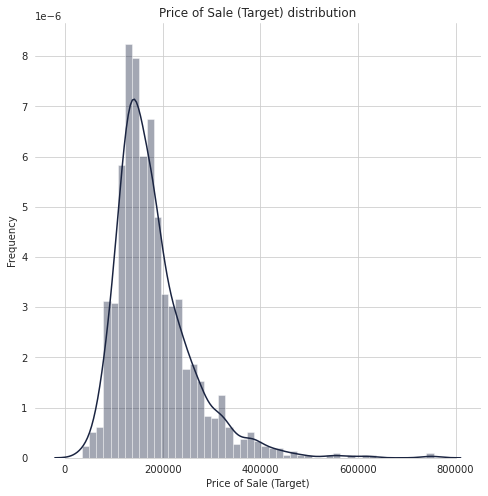

In [ ]:
# Lets take a look at our y - values
f, ax = plt.subplots(figsize=(8, 8))
sns.distplot(train['SalePrice']);
ax.set(ylabel="Frequency")
ax.set(xlabel="Price of Sale (Target)")
ax.set(title="Price of Sale (Target) distribution")
sns.despine(trim=True, left=True)
plt.show()

#### 1.2 Data Cleaning

In [ ]:
#normalize the y values. We want to take the log in order to make sure our y values are normally distributed
train["SalePrice"] = np.log1p(train["SalePrice"])

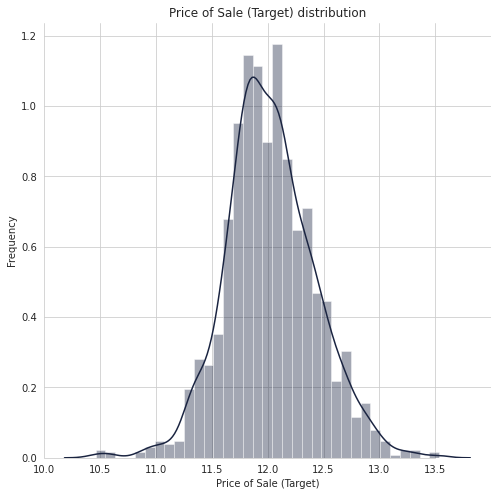

In [ ]:
# Lets take a look at our newly adjusted y - values
f, ax = plt.subplots(figsize=(8, 8))
sns.distplot(train['SalePrice']);
ax.set(ylabel="Frequency")
ax.set(xlabel="Price of Sale (Target)")
ax.set(title="Price of Sale (Target) distribution")
sns.despine(trim=True, left=True)
plt.show()

In [ ]:
# Removing Outliers with the IQR Method
# https://towardsdatascience.com/practical-implementation-of-outlier-detection-in-python-90680453b3ce
Q1=train['SalePrice'].quantile(0.25)
Q3=train['SalePrice'].quantile(0.75)
IQR=Q3-Q1

min_price = Q1-1.5*IQR
max_price = Q3+1.5*IQR

train = train.drop(train[train.SalePrice < min_price].index)
train = train.drop(train[train.SalePrice > max_price].index)



In [ ]:
# Split features and labels
y_train = train['SalePrice'].reset_index(drop=True)
X_train = train.drop(['SalePrice'], axis=1)
X_test = test

# We concatenate both in order that we do our transformations on both the training and testing set.
X_total = pd.concat([X_train, X_test]).reset_index(drop=True)
X_total.shape

(2891, 79)

In [ ]:
## Deal with Missing Values

total = X_total.isnull().sum().sort_values(ascending=False)
percent = (X_total.isnull().sum()/X_total.isnull().count()).sort_values(ascending=False)
df_NaNs = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
df_NaNs.head(20)


,Total,Percent
PoolQC,2882,0.996887
MiscFeature,2788,0.964372
Alley,2696,0.932549
Fence,2326,0.804566
FireplaceQu,1406,0.486337
LotFrontage,484,0.167416
GarageCond,150,0.051885
GarageQual,150,0.051885
GarageYrBlt,150,0.051885
GarageFinish,150,0.051885


In [ ]:
X_total = X_total.drop((df_NaNs[df_NaNs['Percent'] > 0.02]).index,1)
X_total.shape

(2891, 63)

[Text(0.5, 1.0, '% of NaNs by Column')]

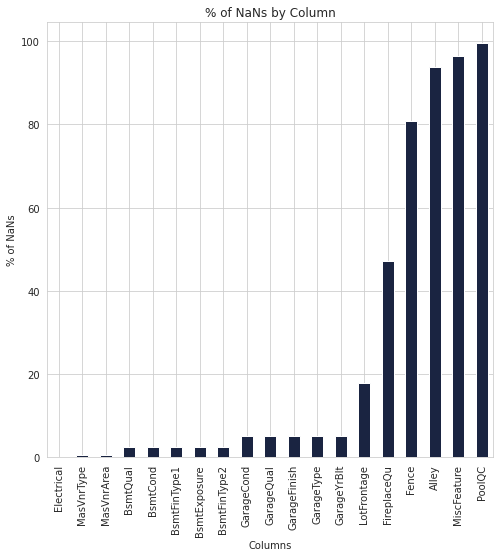

In [ ]:
# Plotting the Missing Values
f, ax = plt.subplots(figsize=(8, 8))
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
# Tweak the visual presentation
ax.set(ylabel="% of NaNs")
ax.set(xlabel="Columns")
ax.set(title="% of NaNs by Column")


In [ ]:
# In order to treat all categorical columns correctly, we transform them into strings 
X_total['MSSubClass'] = X_total['MSSubClass'].apply(str)
X_total['YrSold'] = X_total['YrSold'].astype(str)
X_total['MoSold'] = X_total['MoSold'].astype(str)

In [ ]:
# Fill the Columns with their most frequent value
X_total['Functional'] = X_total['Functional'].fillna('Typ')
X_total['Electrical'] = X_total['Electrical'].fillna("SBrkr")
X_total['KitchenQual'] = X_total['KitchenQual'].fillna("TA")
X_total['Exterior1st'] = X_total['Exterior1st'].fillna(X_total['Exterior1st'].mode()[0])
X_total['Exterior2nd'] = X_total['Exterior2nd'].fillna(X_total['Exterior2nd'].mode()[0])
X_total['SaleType'] = X_total['SaleType'].fillna(X_total['SaleType'].mode()[0])
X_total['MSZoning'] = X_total.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# For the categorical columns where we have no idea into how to fill NA's, we fill them with 'None'
objects = []
for i in X_total.columns:
    if X_total[i].dtype == object:
        objects.append(i)

X_total.update(X_total[objects].fillna('None'))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X_total.columns:
    if X_total[i].dtype in numeric_dtypes:
        numeric.append(i)

X_total.update(X_total[numeric].fillna(0))    

In [ ]:
#Check if there are missing values 
total = X_total.isnull().sum().sort_values(ascending=False)
percent = (X_total.isnull().sum()/X_total.isnull().count()).sort_values(ascending=False)
df_NaNs = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
df_NaNs.head(20)

,Total,Percent
SaleCondition,0,0.0
OverallCond,0,0.0
BsmtFinSF2,0,0.0
BsmtFinSF1,0,0.0
Foundation,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0
MasVnrArea,0,0.0
MasVnrType,0,0.0
Exterior2nd,0,0.0


In [ ]:
# Sanity Check
X_total.shape

(2891, 63)

#### 1.3 Data Augmentation (adding Dummies)

In [ ]:
X_total = pd.get_dummies(X_total).reset_index(drop=True)
X_total.shape

(2891, 256)

In [ ]:
X_total.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_None,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,8450,7,5,2003,2003,196.0,70

In [ ]:
# Let's split the X values back into train and test (for kaggle predictions)
X_train = X_total.iloc[:len(y_train), :]
X_test = X_total.iloc[len(y_train):, :]


# Let's split the test set into train and testing data again (for our predictions)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.33, random_state=420)

#### 2 - Predictions and Models


#### 2.1 Baseline Model (Standard OLS)

In [ ]:
# Let's save all our errors in a central List
errors = {}

In [ ]:
# OLS Regression

# Fitting
X_train_OLS = sm.add_constant(X_train_split, has_constant='add')
model = sm.OLS(y_train_split, X_train_OLS)
results = model.fit()

# Predictions
X_test_OLS = sm.add_constant(X_test_split, has_constant='add')
y_hat = results.predict(X_test_OLS)

MSE_OLS = mean_squared_error(y_test_split, y_hat)
print("Mean Squared Error of OLS Model:", MSE_OLS)

RMSE_OLS = np.sqrt(mean_squared_error(y_test_split, y_hat))
print("Root Mean Squared Error of OLS Model:", RMSE_OLS)

errors['OLS'] = (RMSE_OLS, np.nan)

Mean Squared Error of OLS Model: 0.02768234621014549
Root Mean Squared Error of OLS Model: 0.1663801256465011


#### 2.1 Ridge (CV)

In [ ]:
# We use K-fold Cross validation to find the best RMSE
kf = KFold(n_splits=10, random_state=0)

# Using RMSE as an error metric (like kaggle does)
def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

error = cv_rmse(ridge)
print("RMSE of Ridge Model:" , error.mean())
errors['Ridge'] = (error.mean(), error.std())

RMSE of Ridge Model: 0.12829177098411504


#### 2.2 Lasso (CV)

In [ ]:
# We use K-fold Cross validation to find the best RMSE
kf = KFold(n_splits=10, random_state=0)

# Using RMSE as an error metric (like kaggle does)
def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

# Lasso Regressor
lasso_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=ridge_alphas, cv=kf))

error = cv_rmse(lasso)
print("RMSE of Lasso Model:" , error.mean())
errors['Lasso'] = (error.mean(), error.std())

RMSE of Lasso Model: 0.1251164035702435


#### 2.3 Random Forest Regression

In [ ]:
# We use K-fold Cross validation to find the best RMSE
kf = KFold(n_splits=10, random_state=0)

# Using RMSE as an error metric (like kaggle does)
def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=0)

error = cv_rmse(rf)
print("RMSE of Random Forest Model:" , error.mean())
errors['RF'] = (error.mean(), error.std())

RMSE of Random Forest Model: 0.13178018840106576


#### 2.4 Gradient Boosting

In [ ]:
# We use K-fold Cross validation to find the best RMSE
kf = KFold(n_splits=10, random_state=0)

# Using RMSE as an error metric (like kaggle does)
def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

GBoost = GradientBoostingRegressor(n_estimators=6000, 
                                   learning_rate=0.01,
                                   max_depth=4, 
                                   max_features='sqrt',
                                   min_samples_leaf=15, 
                                   min_samples_split=10, 
                                   loss='huber', 
                                   random_state =42)

error = cv_rmse(GBoost)
print("RMSE of Gradient Boosting Model:" , error.mean())
errors['Gradient Boosting'] = (error.mean(), error.std())

RMSE of Gradient Boosting Model: 0.10777906775814136


#### 2.5 Neural Network


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import datetime

from tensorflow.keras.layers.experimental import preprocessing
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define the DNN Model

model = keras.models.Sequential()
model.add(keras.layers.Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(64, kernel_initializer='normal', activation="relu"))
model.add(keras.layers.Dense(32, kernel_initializer='normal', activation="relu"))
model.add(keras.layers.Dense(1, kernel_initializer='normal',activation='linear'))

# Compile
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

# Get Summary of Model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 43,265
Trainable params: 43,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=250, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(factor=0.01, cooldown=0, patience=10, min_lr=0.1e-8)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") #This is for tensorboard (if used)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) #This is for tensorboard (if used)

history = model.fit(X_train_split, y_train_split, epochs=2500, validation_data=(X_test_split, y_test_split),callbacks=[tensorboard_callback, early_stopper])

Epoch 1/2500
36/36 [==============================] - 3s 23ms/step - loss: 4.0565 - mean_absolute_error: 4.0565 - val_loss: 1.3337 - val_mean_absolute_error: 1.3337
Epoch 2/2500
36/36 [==============================] - 0s 4ms/step - loss: 0.9492 - mean_absolute_error: 0.9492 - val_loss: 0.3300 - val_mean_absolute_error: 0.3300
Epoch 3/2500
36/36 [==============================] - 0s 4ms/step - loss: 0.4855 - mean_absolute_error: 0.4855 - val_loss: 0.9579 - val_mean_absolute_error: 0.9579
Epoch 4/2500
36/36 [==============================] - 0s 4ms/step - loss: 0.6597 - mean_absolute_error: 0.6597 - val_loss: 0.8323 - val_mean_absolute_error: 0.8323
Epoch 5/2500
36/36 [==============================] - 0s 4ms/step - loss: 0.6952 - mean_absolute_error: 0.6952 - val_loss: 0.4663 - val_mean_absolute_error: 0.4663
Epoch 6/2500
36/36 [==============================] - 0s 7ms/step - loss: 0.3180 - mean_absolute_error: 0.3180 - val_loss: 0.7272 - val_mean_absolute_error: 0.7272
Epoch 7/2500
36

In [ ]:
# Check MSE on testing set
test_predictions = model.predict(X_test_split).flatten()

RMSE_DNN = np.sqrt(mean_squared_error(y_test_split, test_predictions))
print("Root Mean Squared Error of DNN Model                   :", RMSE_DNN)

errors['DNN'] = (RMSE_DNN, np.nan)


Root Mean Squared Error of DNN Model                   : 0.11719057350523669


#### 2.7 Hybrid Model

In [ ]:
ridge_model = ridge.fit(X_train, y_train)
lasso_model = lasso.fit(X_train, y_train)
rf_model = rf.fit(X_train, y_train)
gb_model = GBoost.fit(X_train, y_train)

ridge_p = ridge_model.predict(X_test_split)
lasso_p = lasso_model.predict(X_test_split)
rf_p = rf_model.predict(X_test_split)
gb_p = GBoost.predict(X_test_split)
NN_p = test_predictions

In [ ]:
predictions_hybrid_2 = 0.25*ridge_p + 0.15* lasso_p + 0.3*gb_p + 0.3*NN_p

RMSE_Hybrid_2 = np.sqrt(mean_squared_error(y_test_split, predictions_hybrid_2))
print("Root Mean Squared Error of Hybrid Model2:", RMSE_Hybrid_2)

predictions_hybrid_3 = 0.33*ridge_p + 0.34*gb_p + 0.33*NN_p

RMSE_Hybrid_3 = np.sqrt(mean_squared_error(y_test_split, predictions_hybrid_3))
print("Root Mean Squared Error of Hybrid Model3:", RMSE_Hybrid_3)

predictions_hybrid_4 = 0.15*ridge_p + 0.15*lasso_p + 0.1*rf_p + 0.35*gb_p + 0.25*NN_p

RMSE_Hybrid_4 = np.sqrt(mean_squared_error(y_test_split, predictions_hybrid_4))
print("Root Mean Squared Error of Hybrid Model2:", RMSE_Hybrid_4)

errors['Hybrid'] = RMSE_Hybrid_4, np.nan

Root Mean Squared Error of Hybrid Model2: 0.08329815659381706
Root Mean Squared Error of Hybrid Model3: 0.08215962955569178
Root Mean Squared Error of Hybrid Model2: 0.07826357028781757


#### 3 - Comparison

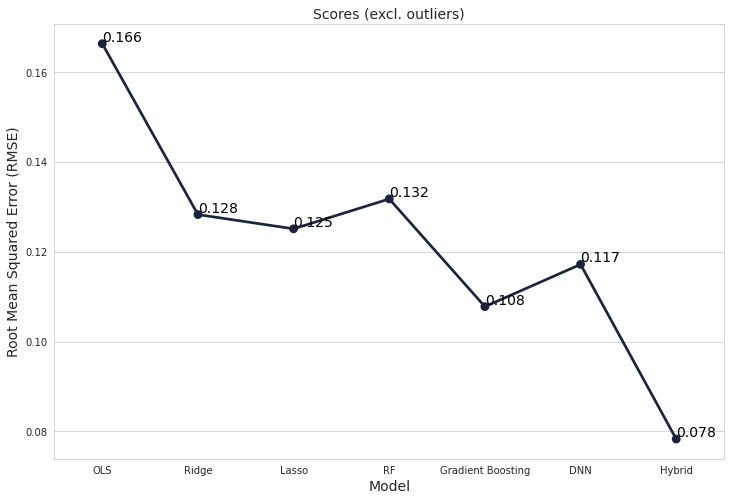

In [ ]:
# Plot the predictions for each model

fig = plt.figure(figsize=(12, 8))

ax = sns.pointplot(x=list(errors.keys()), y=[error for error, _ in errors.values()])
for i, error in enumerate(errors.values()):
    ax.text(i, error[0]+ 0.0005, '{:.3f}'.format(error[0]), horizontalalignment='left', size=14, color='black')

plt.ylabel('Root Mean Squared Error (RMSE)', size= 14)
plt.xlabel('Model', size=14)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.title('Scores (excl. outliers)', size=14)

plt.show()